In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Steps to be performed for vehicle detection
#### 1. Features to use (Color & Gradient)
#### 2. Choose & train classifier
#### 3. Sliding window technique to search for vehicles
#### 4. Implement in a video stream

### Classes to hold values for HOG & Color hist

In [2]:
class Hog_Parameters():
    def __init__(self, orient, pix_per_cell, cell_per_block, hog_channel, visualize=False, feature_vec=True):
        self.orient = orient
        self.pix_per_cell = (pix_per_cell, pix_per_cell)
        self.cell_per_block = (cell_per_block, cell_per_block)
        self.hog_channel = hog_channel
        self.visualize = visualize
        self.feature_vector = feature_vec

class Color_Parameters():
    def __init__(self, color_space, spatial_size, hist_bins, hist_range):
        self.color_space = color_space
        self.spatial_size = (spatial_size, spatial_size)
        self.hist_bins = hist_bins
        self.hist_range = hist_range

### Vehicle detector class

In [3]:
# This class contains the core methods for extracting features (HOG as well as color hist.)
# Ctor takes in the paths to car & not car images and coordinates to be used for sliding windows
# Provides methods for classification, sliding window search, detecting false positives and generating heatmaps

class VehicleDetector():
    
    def __init__(self, cars_folder, notcars_folder, sliding_window_points):
        self.cars = glob.glob(cars_folder)
        self.notcars = glob.glob(notcars_folder) 
        self.sliding_window_points = sliding_window_points
        self.car_imgs = []
        self.notcar_imgs = []
        for car_img in self.cars:
            self.car_imgs.append(mpimg.imread(car_img))
        for notcar_img in self.notcars:
            self.notcar_imgs.append(mpimg.imread(notcar_img))
        
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the RGB channels separately
        rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def bin_spatial(self, img, color_space='RGB', size=(32, 32)):
        # Convert image to new color space (if specified)
        feature_image = np.copy(img)             
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, size).ravel() 
        # Return the feature vector
        return features
    
    # Define a function to return HOG features and visualization (if flag is set)
    def get_hog_features(self, img, hog_features): 
        hog_image = None
        if hog_features.visualize:
            features, hog_image = hog(img, orientations=hog_features.orient, pixels_per_cell=hog_features.pix_per_cell,
                                      cells_per_block=hog_features.cell_per_block, transform_sqrt=False, 
                                      visualise=hog_features.visualize, feature_vector=hog_features.feature_vector)
        else:
            features = hog(img, orientations=hog_features.orient, pixels_per_cell=hog_features.pix_per_cell,
                                      cells_per_block=hog_features.cell_per_block, transform_sqrt=False, 
                                      visualise=hog_features.visualize, feature_vector=hog_features.feature_vector)
        return features, hog_image
    
    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_features(self, img_type, color_features): 
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        if img_type == 'cars':
            imgs = self.car_imgs
        else:
            imgs = self.notcar_imgs
        for image in imgs:
            # apply color conversion if other than 'RGB'
            feature_image = self.convert_color(image, color_features.color_space)
            # Apply bin_spatial() to get spatial color features
            spatial_features = self.bin_spatial(feature_image, size=color_features.spatial_size)
            # Apply color_hist() also with a color space option now
            hist_features = self.color_hist(feature_image, nbins=color_features.hist_bins, bins_range=color_features.hist_range)
            # Append the new feature vector to the features list
            features.append(np.concatenate((spatial_features, hist_features)))
        # Return list of feature vectors
        return features

    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_hog_features(self, img_type, hog_parms, cspace='RGB'):
        # Create a list to append feature vectors to
        features = []
        if img_type == 'cars':
            imgs = self.car_imgs
        else:
            imgs = self.notcar_imgs
        # Iterate through the list of images
        for image in imgs:
            # apply color conversion if other than 'RGB'
            feature_image = self.convert_color(image,cspace)
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_parms.hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    f, hog_viz = self.get_hog_features(feature_image[:,:,channel], hog_parms)
                    hog_features.append(f)
                hog_features = np.ravel(hog_features)        
            else:
                hog_features, hog_viz = self.get_hog_features(feature_image[:,:,hog_channel], hog_parms)
            # Append the new feature vector to the features list
            features.append(hog_features)
        # Return list of feature vectors
        return features, hog_viz
    
    def convert_color(self, image, cspace='RGB'):
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        return feature_image
    
    # Define a function to extract features from a single image window
    def single_img_features(self, img, color_parms, hog_parms, spatial_feat=True, hist_feat=True, hog_feat=True):
        #1) Define an empty list to receive features
        img_features = []
        #2) Apply color conversion if other than 'RGB'
        feature_image = self.convert_color(img, color_parms.color_space)
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = self.bin_spatial(feature_image, size=color_parms.spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = self.color_hist(feature_image, nbins=color_parms.hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_parms.hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    f, hog_viz = self.get_hog_features(feature_image[:,:,channel],hog_parms)
                    hog_features.extend(f)      
            else:
                hog_features, hog_viz = self.get_hog_features(feature_image[:,:,hog_parms.hog_channel], hog_parms)
            #8) Append features to list
            img_features.append(hog_features)

        #9) Return concatenated array of features
        return np.concatenate(img_features), hog_viz

    def extract_all_features(self, img_type, color_parms, hog_parms, spatial_feat, hist_feat, hog_feat): 
        # Create a list to append feature vectors to
        features = []
        if img_type == 'cars':
            imgs = self.car_imgs
        else:
            imgs = self.notcar_imgs
        # Iterate through the list of images
        for image in imgs:
            file_features, hog_viz = self.single_img_features(image, color_parms, hog_parms, spatial_feat, hist_feat, hog_feat)
            features.append(file_features)
        # Return list of feature vectors
        return features, hog_viz

    def hog_classify_visualize(self, hog_parms, color_space):
        msg = []
        t=time.time()
        car_features, car_hog_viz = self.extract_hog_features('cars', hog_parms, cspace=color_space)
        notcar_features, notcar_hog_viz = self.extract_hog_features('notcars', hog_parms, cspace=color_space)
        t2 = time.time()
        msg.append('Time taken to extract HOG features: ' + str(round(t2-t, 2)))

        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)            

        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        msg.append('\nOrientation: ' + str(hog_parms.orient) + '\nPixels per cell: ' + str(hog_parms.pix_per_cell)  + '\nCells per block: ' + str(hog_parms.cell_per_block) + 
                    '\nColorspace: '+ color_space)
        msg.append('\n' + 'Feature vector length: ' + str(len(X_train[0])))
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        msg.append('\nTime taken to train SVC: ' + str(round(t2-t, 2)))
        # Check the score of the SVC
        msg.append('\nTest Accuracy of SVC: ' + str(round(svc.score(X_test, y_test), 4)))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        msg.append('\nPrediction: ' + str(svc.predict(X_test[0:n_predict])))
        msg.append('\nActual: ' + str(y_test[0:n_predict]))
        t2 = time.time()
        msg.append('\nTime taken to predict '  + str(n_predict) + ' labels: '+ str(round(t2-t, 5)) + ' seconds')
        return car_hog_viz, notcar_hog_viz, ''.join(msg)
    
    
    def color_classify_visualize(self, color_parms):
        msg = []
        car_features = self.extract_features('cars', color_parms)
        notcar_features = self.extract_features('notcars', color_parms)

        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        msg.append('Spatial binning size: ' + str(color_parms.spatial_size) + '\nhistogram bins: ' + str(color_parms.hist_bins))
        msg.append('\nFeature vector length: ' + str(len(X_train[0])))
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        msg.append('\nTime to train SVC: ' + str(round(t2-t, 2)))
        # Check the score of the SVC
        msg.append('\nTest Accuracy of SVC: ' + str(round(svc.score(X_test, y_test), 4)))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        msg.append('\nSVC prediction: ' + str(svc.predict(X_test[0:n_predict])))
        msg.append('\nActual: ' +  str(y_test[0:n_predict]))
        t2 = time.time()
        msg.append('\nTime to predict: ' + str(round(t2-t, 5)) + ' seconds')
        car_img = self.car_imgs[np.random.randint(0, len(self.cars)-1)]
        notcar_img = self.notcar_imgs[np.random.randint(0, len(self.notcars)-1)]
        return car_img, notcar_img, ''.join(msg)
        
    
    
    def hog_color_classify_visualize(self, hog_parms, color_parms):
        msg = []
        t=time.time()
        car_features, car_hog_viz = self.extract_all_features('cars', color_parms=color_parms, hog_parms=hog_parms, spatial_feat=True, hist_feat=True, hog_feat=True)
        notcar_features, notcar_hog_viz = self.extract_all_features('notcars', color_parms=color_parms, hog_parms=hog_parms, spatial_feat=True, hist_feat=True, hog_feat=True)
        t2 = time.time()
        msg.append('Time taken to extract all features: ' + str(round(t2-t, 2)))
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)            

        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        msg.append('\nOrientation: ' + str(hog_parms.orient) + '\nPixels per cell: ' + str(hog_parms.pix_per_cell)  + 
                   '\nCells per block: ' + str(hog_parms.cell_per_block) + '\nColorspace: '+ color_parms.color_space)

        msg.append('\nFeature vector length:' + str(len(X_train[0])))
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        msg.append('\nTime taken to train SVC: ' + str(round(t2-t, 2)))
        # Check the score of the SVC
        msg.append('\nTest Accuracy of SVC: ' + str(round(svc.score(X_test, y_test), 4)))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        msg.append('\nPrediction: ' + str(svc.predict(X_test[0:n_predict])))
        msg.append('\nActual: ' + str(y_test[0:n_predict]))
        t2 = time.time()
        msg.append('\nTime taken to predict: ' + str(round(t2-t, 5)) + ' seconds')
        return car_hog_viz, notcar_hog_viz, ''.join(msg), svc, X_scaler
    
    # Define a function that takes an image,
    # start and stop positions in both x and y, 
    # window size (x and y dimensions),  
    # and overlap fraction (for both x and y)
    def slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list

    # Feeds the passed in image, window by window to the classifier to predict if a car is present in a given window
    def search_windows(self, img, windows, clf, scaler, color_parms, hog_parms, spatial_feat, 
                                hist_feat, hog_feat): 

        #1) Create an empty list to receive positive detection windows
        on_windows = []
        #2) Iterate over all windows in the list
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            #4) Extract features for that window using single_img_features()
            hog_parms.visualise = False # Dont need the HOG viz here
            features, _ = self.single_img_features(test_img, color_parms, hog_parms, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier        
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        #8) Return windows for positive detections
        return on_windows

    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
        imcopy = np.copy(img)
        for bbox in bboxes:
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        return imcopy
    
    def add_heat(self, heatmap, bbox_list):
        for box in bbox_list:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        return heatmap
    
    def apply_threshold(self, heatmap, threshold):
        heatmap[heatmap <= threshold] = 0
        return heatmap

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    def extract_hot_windows(self, img):
        hot_windows = []
        #1. Get sliding window for the image frame
        for xy_window, overlap, y_start_stop, x_start_stop in zip(self.sliding_window_points.xy_windows, self.sliding_window_points.xy_overlaps, 
                                                                  self.sliding_window_points.y_start_stops, self.sliding_window_points.x_start_stops):
            windows = self.slide_window(img, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=(overlap,overlap))

        #2. Search for vehicles in the extracted window
            found_window = self.search_windows(img, windows, final_SVC, final_scaler, color_parms2, hog_parms2, spatial_feat=True, 
                                hist_feat=True, hog_feat=True)
            hot_windows += found_window
        return hot_windows

    def process_video_images(self, img):
        img_scaled = img.astype(np.float32)/255
        hot_windows = self.extract_hot_windows(img_scaled)

        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat_aug = self.add_heat(heat, hot_windows)
        heat_thresh = self.apply_threshold(heat_aug,4)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(img, labels)
        return draw_img
    
    def visualize_heatmap(self, img, no_car_in_frame=False):
        draw_img = np.copy(img)
        img_scaled = img.astype(np.float32)/255
        hot_windows = []

        #1. Get car found windows for the specified coords
        hot_windows = self.extract_hot_windows(img_scaled)

        #2: Generate hot windows image
        hot_windows_img = self.draw_boxes(draw_img, hot_windows, color=(0, 255, 255), thick=6) 

        #3: Generate heatmap
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = self.add_heat(heat,hot_windows)
        #4. Remove false positives
        heat = self.apply_threshold(heat,4)
        #5. Create image with heatmap    
        heat_map_img = np.clip(heat, 0, 255)    

        #6: Generate found image with boxes drawn
        labels = label(heat_map_img)
        final_window_img = self.draw_labeled_bboxes(draw_img, labels)

        #7. Display all the images

        title1 = 'Sliding Windows with cars'
        title2 = 'Heatmap with cars'
        title3 = 'Bounded box with cars'

        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,7))
        ax1.imshow(hot_windows_img)
        ax2.imshow(heat_map_img)
        ax3.imshow(final_window_img)
        outfile = 'output_images/heatmap_viz_cars.png'    
        if no_car_in_frame: # in case, the image didn't have any cars false +ve detected
            title1 = 'Sliding Windows no cars'
            title2 = 'Heatmap no cars'
            title3 = 'Bounded box no cars'
            outfile = 'output_images/heatmap_viz_nocars.png'

        ax1.set_title(title1, fontsize=20)
        ax2.set_title(title2, fontsize=20)
        ax3.set_title(title3, fontsize=20)
        f.savefig(outfile)
        f.show()


#### Set image path & instantiate class

In [4]:
# window points for sliding windows
class Sliding_Window_Points():
    def __init__(self, xy_windows, xy_overlaps, x_start_stops, y_start_stops):
        self.xy_windows = xy_windows
        self.xy_overlaps = xy_overlaps
        self.x_start_stops = x_start_stops
        self.y_start_stops = y_start_stops

#xy_windows = [(64, 64),(76,76),(128, 128)]
sliding_window_coords = Sliding_Window_Points(xy_windows = [(64,64),(64, 64),(96, 96),(76, 76)],
                                              xy_overlaps = [0.50, 0.50, 0.75, 0.80],
                                              x_start_stops = [[575,1280], [640, 1280],[760, 1280],[760, 1280]],
                                              y_start_stops = [[490, 720], [375, 720],[385,720],[395,720]])

cars_folder = './vehicles/**/*.png'
notcars_folder = './non-vehicles/**/*.png'
vehicle_detector = VehicleDetector(cars_folder, notcars_folder, sliding_window_coords)

#### Color transform & binning - classification & visualization

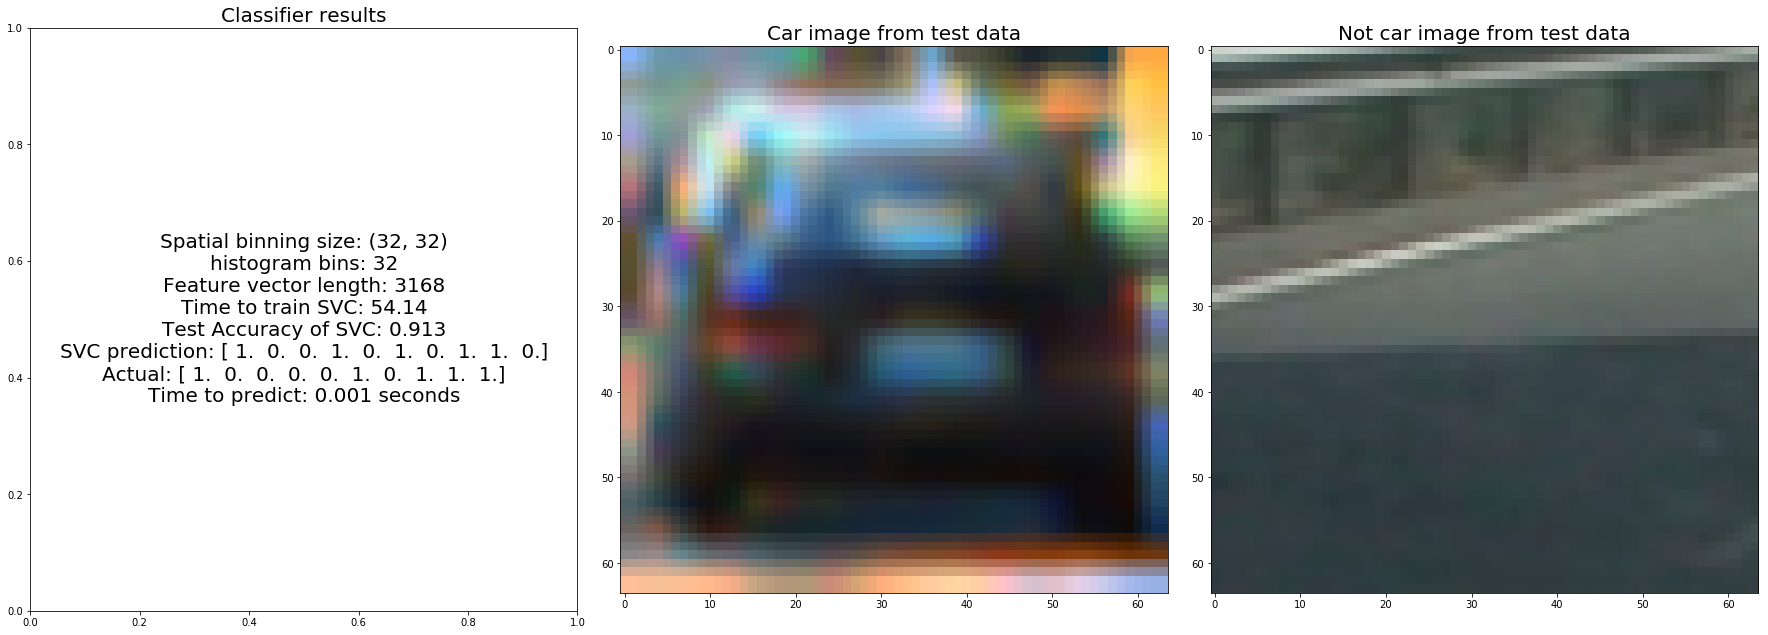

In [7]:
# set color parms for color & hist x'formation
color_parms = Color_Parameters(color_space='RGB', spatial_size=32, hist_bins=32, hist_range=(0,256))
# call method to extract color features, apply classification and visualize 
car_img, notcar_img, msg  = vehicle_detector.color_classify_visualize(color_parms)
# display classification data & images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
#plt.imsave('./output_images/car_img.png', car_img)
ax1.text(0.5, 0.5, msg, horizontalalignment='center', verticalalignment='center', fontsize=20)
ax1.set_title('Classifier results', fontsize=20)
ax2.imshow(car_img)
ax2.set_title('Car image from test data', fontsize=20)

#plt.imsave('./output_images/notcar_img.png', notcar_img)
ax3.imshow(notcar_img)
ax3.set_title('Not car image from test data', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(fname='./output_images/car_not_car.png')

#### HOG classify & visualize

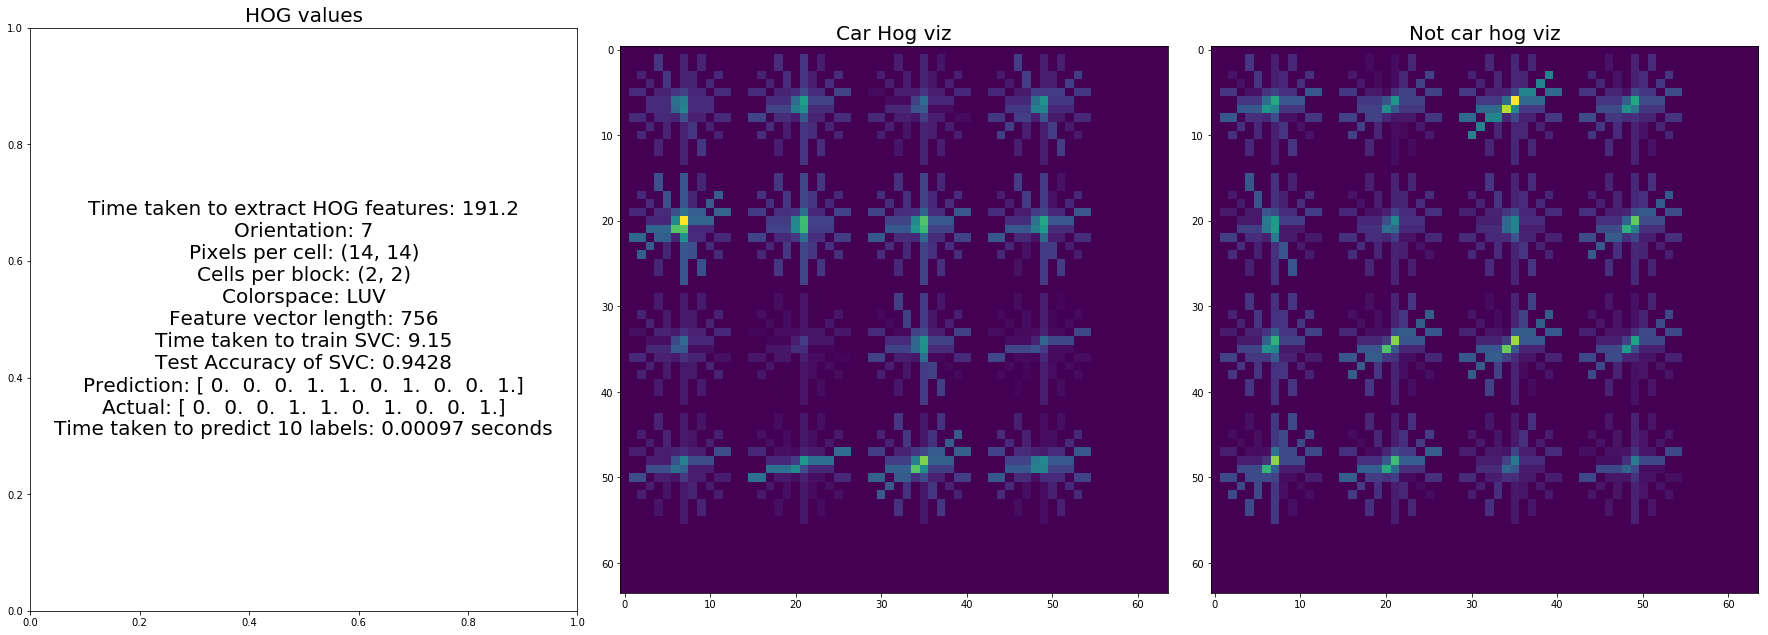

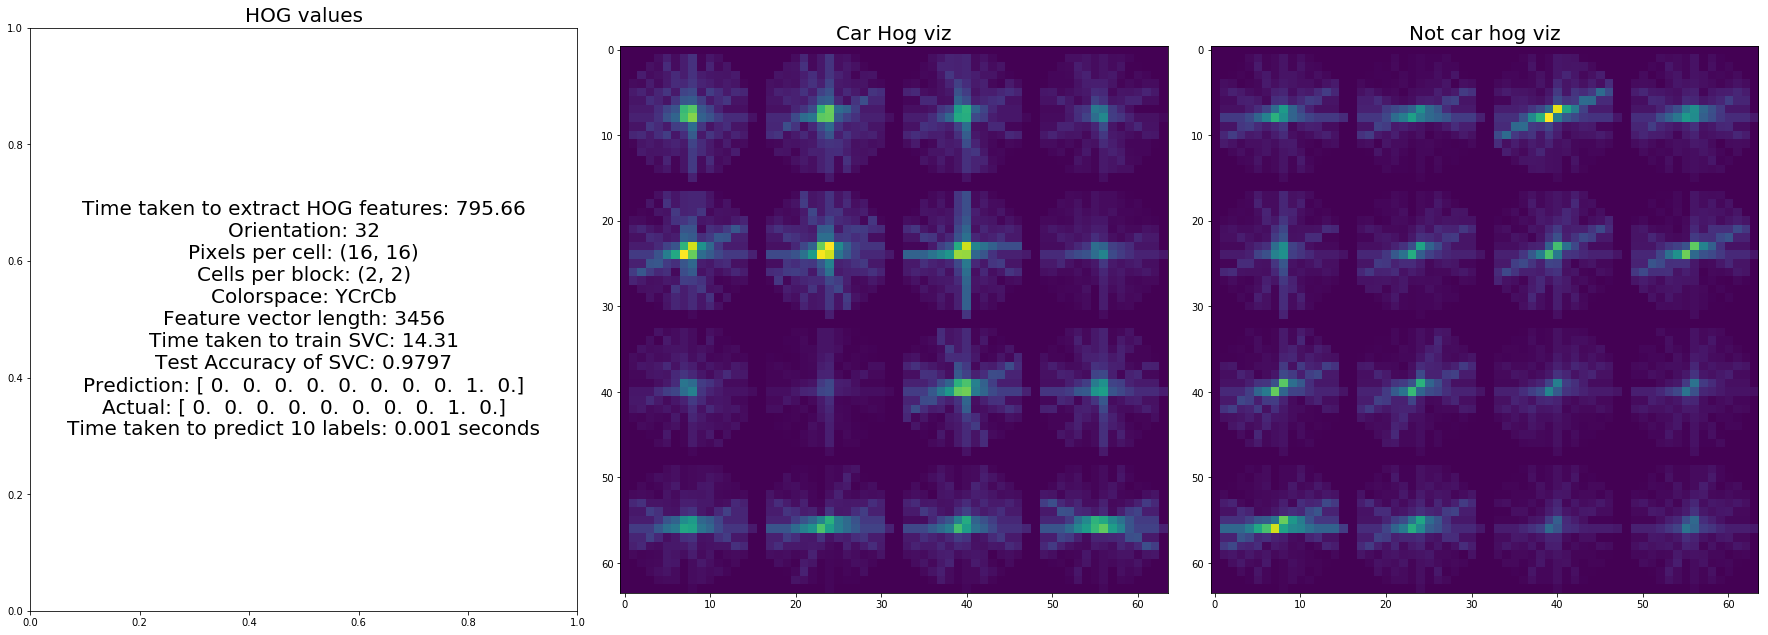

In [8]:
colorspace1 = 'LUV'
hog_parms1 = Hog_Parameters(orient=7, pix_per_cell=14, cell_per_block=2, hog_channel='ALL', visualize=True, feature_vec=True)

car_hog_viz1, notcar_hog_viz1, msg1 = vehicle_detector.hog_classify_visualize(hog_parms1, colorspace1)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
#plt.imsave('./output_images/car_hog_viz1.png', car_hog_viz1)
ax1.text(0.5, 0.5, msg1, horizontalalignment='center', verticalalignment='center', fontsize=20)
ax1.set_title('HOG values', fontsize=20)
ax2.imshow(car_hog_viz1)
ax2.set_title('Car Hog viz', fontsize=20)

plt.imsave('./output_images/notcar_hog_viz1.png', notcar_hog_viz1)
ax3.imshow(notcar_hog_viz1)
ax3.set_title('Not car hog viz', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('./output_images/hog_viz1.png')

colorspace2 = 'YCrCb'
hog_parms2 = Hog_Parameters(orient=32, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', visualize=True, feature_vec=True)
car_hog_viz2, notcar_hog_viz2, msg2 = vehicle_detector.hog_classify_visualize(hog_parms2, colorspace2)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
#plt.imsave('./output_images/car_hog_viz2.png', car_hog_viz2)
ax1.text(0.5, 0.5, msg2, horizontalalignment='center', verticalalignment='center', fontsize=20)
ax1.set_title('HOG values', fontsize=20)
ax2.imshow(car_hog_viz2)
ax2.set_title('Car Hog viz', fontsize=20)

plt.imsave('./output_images/notcar_hog_viz2.png', notcar_hog_viz2)
ax3.imshow(notcar_hog_viz2)
ax3.set_title('Not car hog viz', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('./output_images/hog_viz2.png')

#### HOG & Color transform and binning classify & visualize

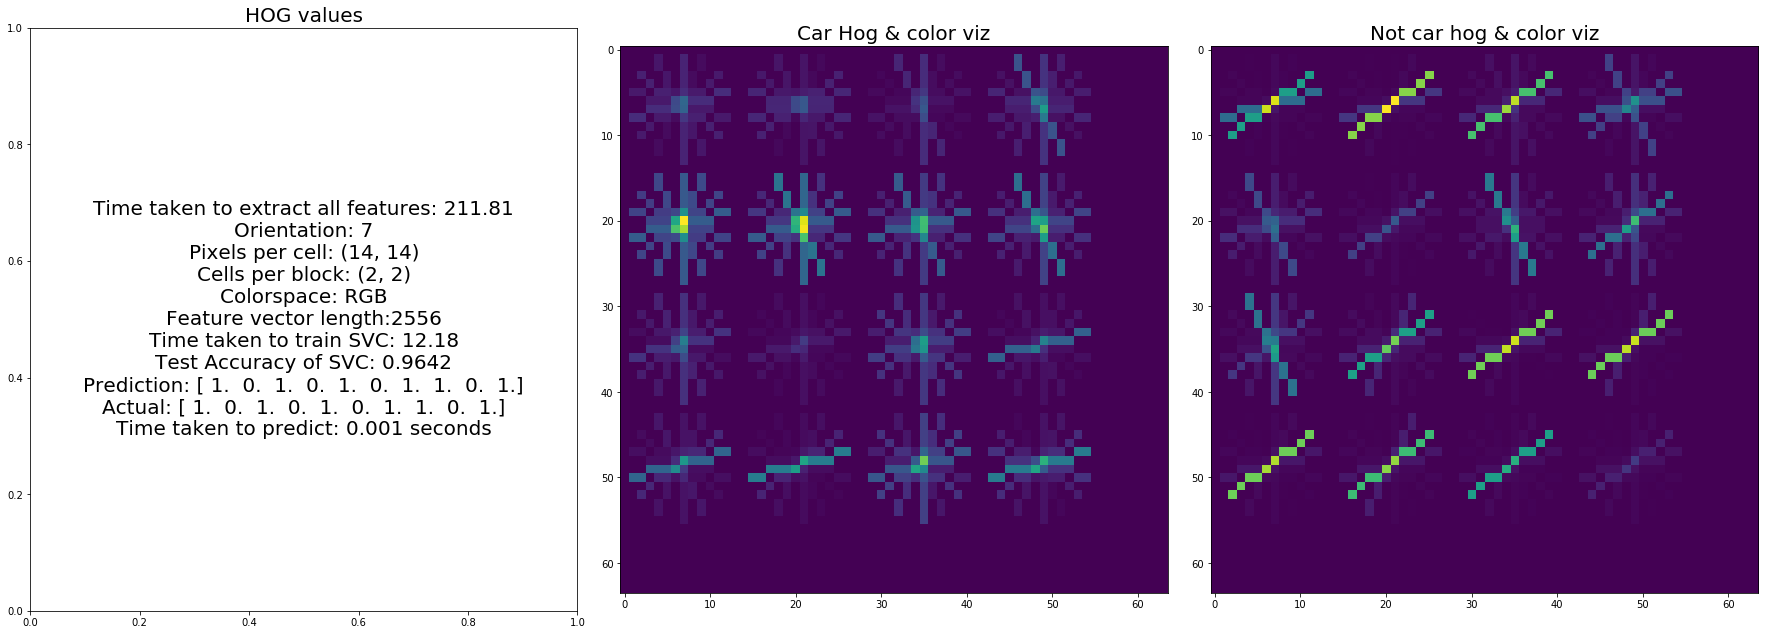

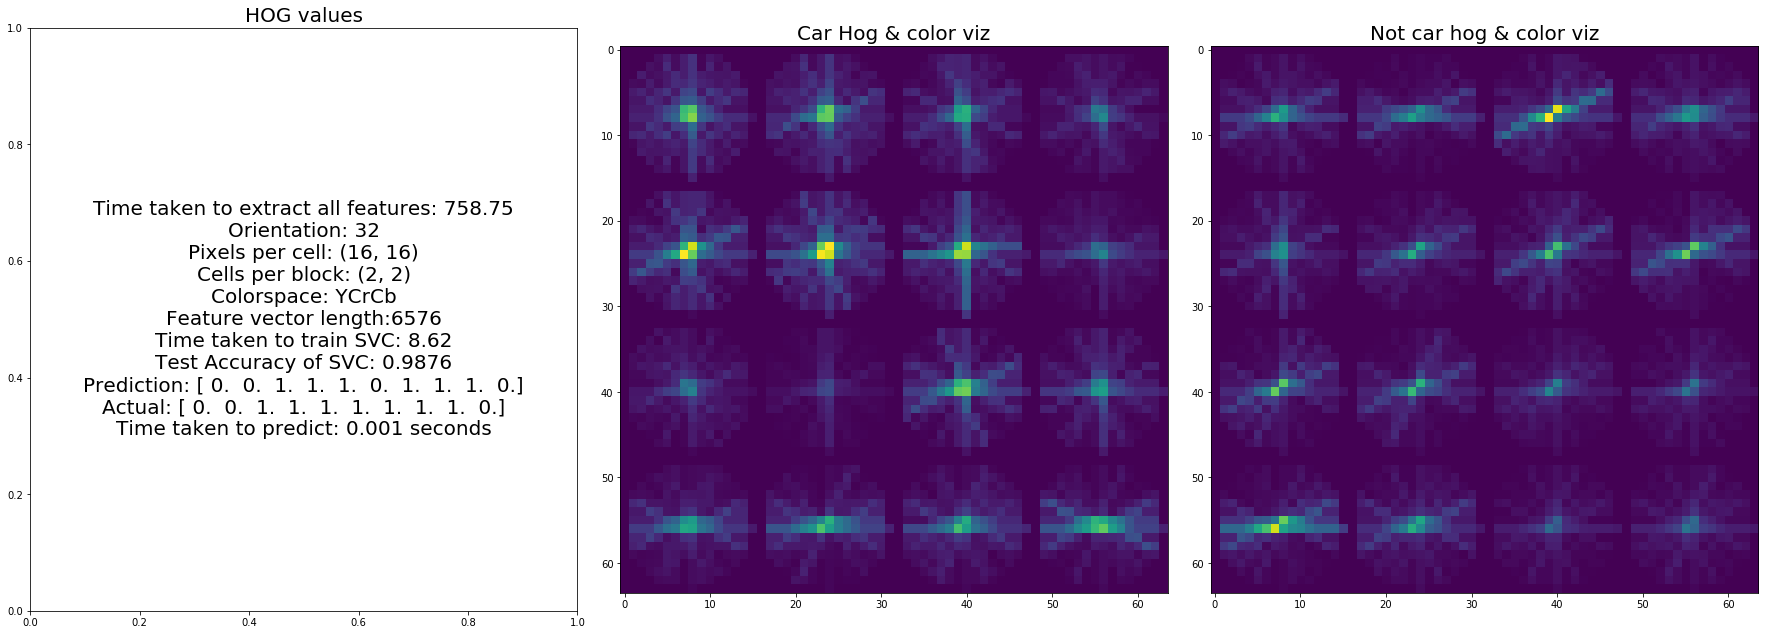

In [9]:

hog_parms1 = Hog_Parameters(orient = 7, pix_per_cell = 14, cell_per_block = 2, hog_channel='ALL', visualize=True, feature_vec=True)
color_parms1 = Color_Parameters(color_space='RGB', spatial_size=24, hist_bins=24, hist_range=(0,256))

car_hog_viz1, notcar_hog_viz1, msg1, _, _ = vehicle_detector.hog_color_classify_visualize(hog_parms1, color_parms1)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
#plt.imsave('./output_images/car_hog_color_viz1.png', car_hog_viz1)
ax1.text(0.5, 0.5, msg1, horizontalalignment='center', verticalalignment='center', fontsize=20)
ax1.set_title('HOG values', fontsize=20)
ax2.imshow(car_hog_viz1)
ax2.set_title('Car Hog & color viz', fontsize=20)

#plt.imsave('./output_images/notcar_hog_color_viz1.png', notcar_hog_viz1)
ax3.imshow(notcar_hog_viz1)
ax3.set_title('Not car hog & color viz', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('./output_images/hog_color_viz1.png')

color_parms2 = Color_Parameters(color_space='YCrCb', spatial_size=32, hist_bins=16, hist_range=(0,256))
hog_parms2 = Hog_Parameters(orient=32, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', visualize=True, feature_vec=True)
car_hog_viz2, notcar_hog_viz2, msg2, final_SVC, final_scaler = vehicle_detector.hog_color_classify_visualize(hog_parms2, color_parms2)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
#plt.imsave('./output_images/car_hog_color_viz2.png', car_hog_viz2)
ax1.text(0.5, 0.5, msg2, horizontalalignment='center', verticalalignment='center', fontsize=20)
ax1.set_title('HOG values', fontsize=20)

ax2.imshow(car_hog_viz2)
ax2.set_title('Car Hog & color viz', fontsize=20)

plt.imsave('./output_images/notcar_hog_color_viz2.png', notcar_hog_viz2)
ax3.imshow(notcar_hog_viz2)
ax3.set_title('Not car hog & color viz', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('./output_images/hog_color_viz2.png')

#### Sliding window image frame

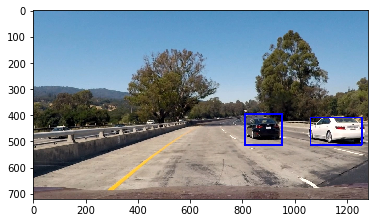

In [10]:
image = mpimg.imread('test_images/test1.jpg')
boxed_img = vehicle_detector.process_video_images(image)
plt.imsave('./output_images/boxed_img.png', boxed_img)
plt.imshow(boxed_img)

#### Multiple detection & false positive

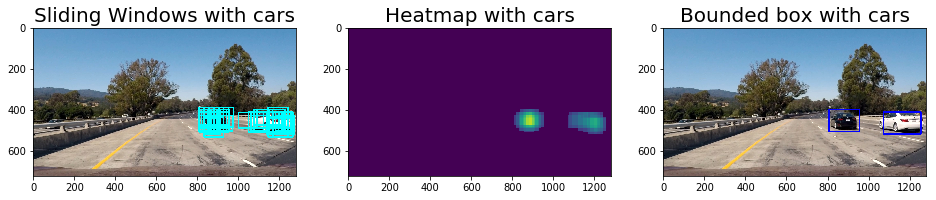

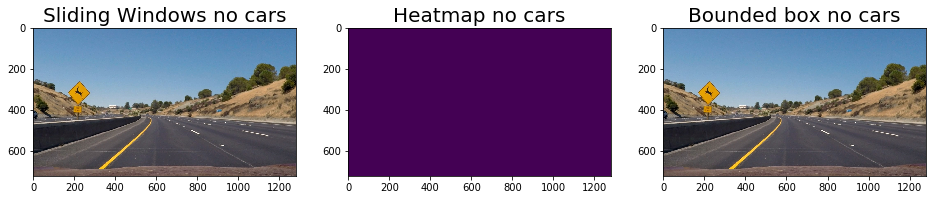

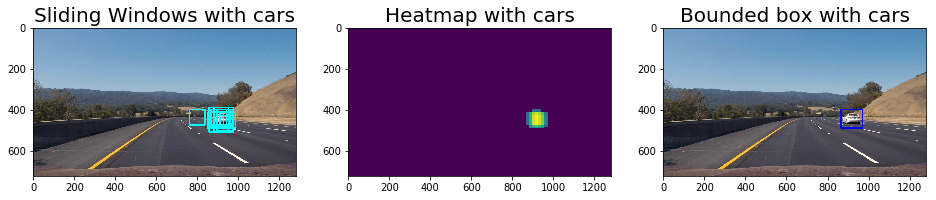

In [14]:
image1 = mpimg.imread('test_images/test1.jpg')
vehicle_detector.visualize_heatmap(image1, no_car_in_frame=False)
image2 = mpimg.imread('test_images/test2.jpg')
vehicle_detector.visualize_heatmap(image2, no_car_in_frame=True)
image3 = mpimg.imread('test_images/test3.jpg')
vehicle_detector.visualize_heatmap(image3, no_car_in_frame=False)

#### Test video pipeline

In [15]:
test_video_output = 'test_video_output.mp4'
test_video = VideoFileClip("test_video.mp4")
processed_test_video = test_video.fl_image(vehicle_detector.process_video_images)
%time processed_test_video.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 38/39 [24:38<00:38, 38.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 24min 39s


#### Project video pipeline

In [17]:
project_video_output = 'project_video_output.mp4'
project_video = VideoFileClip("project_video.mp4")
processed_video = project_video.fl_image(vehicle_detector.process_video_images)
%time processed_video.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:38:39<00:37, 37.75s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 12h 38min 40s
